In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
Nx = 15
Nt = 15
xx = np.linspace(0, 1,Nx)
tt= np.linspace(0, 1, Nt)

x_,t_ = np.meshgrid(xx, tt)
x = (x_.ravel()).reshape(-1,1)
t = (t_.ravel()).reshape(-1,1)
features = np.concatenate((x, t,), 1)



n_samples = features.shape[0]
features.shape, x.shape, t.shape


((225, 2), (225, 1), (225, 1))

Defining tensorflow placeholders for input variables

In [3]:
X = tf.placeholder(tf.float64, shape=(None, features.shape[1]), name='X')
x_tf = tf.placeholder(tf.float64, shape=(None, 1), name='x')
t_tf = tf.placeholder(tf.float64, shape=(None, 1), name='t')

Defining network architecture

In [4]:

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, 40, name='hidden1',
                              activation='elu')
    hidden2 = tf.layers.dense(hidden1, 100, name='hidden2',
                              activation='elu')
    hidden3 = tf.layers.dense(hidden2, 40, name='hidden3',
                              activation='elu')
    output = tf.layers.dense(hidden3, 1, name='outputs')

In [5]:
def u(x):
    return tf.sin(np.pi*x)



The cost function minimizes the differential equation using the trial function w.r.t the network output.

In [6]:
with tf.name_scope('cost'):
    g_trial = (1-t_tf)*u(x_tf) + x_tf*(1-x_tf)*t_tf*output

    g_trial_dt = tf.gradients(g_trial,t_tf)
    g_trial_d2x = tf.gradients(tf.gradients(g_trial,x_tf),x_tf)
    err =  g_trial_dt[0] - g_trial_d2x[0]
    cost = tf.losses.mean_squared_error(tf.zeros_like(err), err)


In [7]:
l_rate = 0.005
with tf.name_scope('train'):
    optimizer = tf.contrib.opt.NadamOptimizer(l_rate)
    training_op = optimizer.minimize(cost)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [8]:
init = tf.global_variables_initializer()

Execution:

In [10]:
n_epochs, batch_size = 50000 , 100
batch_inds = np.arange(n_samples)
n_batches = n_samples//batch_size
curve = np.empty(n_epochs)
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        np.random.shuffle(batch_inds)
        batch_ind = np.array_split(batch_inds, n_batches) 
        
        for ind in batch_ind:        
            X_batch = features[ind]
            x_batch = x[ind]
            t_batch = t[ind]
            sess.run(training_op, feed_dict={X: X_batch,
                                             x_tf: x_batch,
                                             t_tf: t_batch})
        
        curve[epoch] = cost.eval(feed_dict = {X:features,
                                              x_tf: x,
                                              t_tf: t})  
        if epoch%1000 == 0:
            print (epoch, 'cost:', curve[epoch])
            
    result =  g_trial.eval(feed_dict = {X:features,
                                        x_tf: x,
                                        t_tf: t})


0 cost: 10.293733596801758
1000 cost: 0.011006626300513744
2000 cost: 0.02528388611972332
3000 cost: 0.020092030987143517
4000 cost: 0.0008653486147522926
5000 cost: 0.00392195163294673
6000 cost: 0.0015430854400619864
7000 cost: 0.015746911987662315
8000 cost: 0.0015693891327828169
9000 cost: 0.018888136371970177
10000 cost: 0.0012862971052527428
11000 cost: 0.0005649856757372618
12000 cost: 0.00027289093122817576
13000 cost: 0.0004683908773586154
14000 cost: 0.009044296108186245
15000 cost: 0.0006461728480644524
16000 cost: 0.00021612414275296032
17000 cost: 0.0001080618312698789
18000 cost: 0.0010628984309732914
19000 cost: 0.007657711859792471
20000 cost: 0.000420689262682572
21000 cost: 0.0006771956104785204
22000 cost: 0.0005205742199905217
23000 cost: 0.0004576383507810533
24000 cost: 0.00012027798220515251
25000 cost: 9.161279740510508e-05
26000 cost: 0.0002988880733028054
27000 cost: 0.00019768062338698655
28000 cost: 9.333172783954069e-05
29000 cost: 9.703686373541132e-05
300

In [11]:
pred = result.reshape(Nt, Nx)
print (result.shape)

#pred = trial_function(x_, t_, result)
#pred.shape


(225, 1)


In [12]:
def analytical_sol(x, t):
    return np.sin(np.pi*x)*np.exp(-np.pi**2*t)
an = analytical_sol(x_, t_)

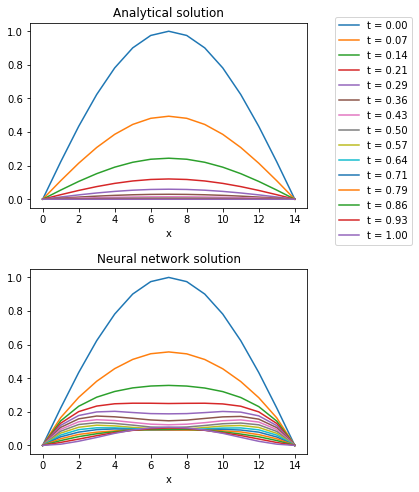

In [13]:
import matplotlib.pyplot as plt


f, axs = plt.subplots(2,2,figsize=(6,7))
plt.subplot(211)
for i in range(0, Nt):
    plt.plot(an[i, :], label= 't = %.2f'%tt[i])
plt.title('Analytical solution')
plt.xlabel('x')
plt.legend(loc=[1.1, -0.2])
plt.subplot(212)
for i in range(0, Nt):
    plt.plot(pred[i, :])
plt.title('Neural network solution')
plt.xlabel('x')

plt.tight_layout()
plt.savefig('nn_result.pdf')
plt.show()



In [14]:
np.max(np.abs(an-pred))

0.16217161743334169

In [39]:
curve.shape
nc = curve.shape[0]//500
curve_plot = np.empty(nc)
plot_points = np.empty(nc)
for i in range(nc):
    curve_plot[i] = np.mean(curve[i*nc: (i+1)*nc])
    plot_points[i] = i*nc*5

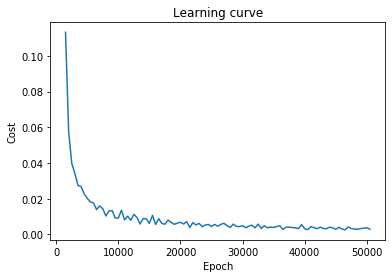

In [43]:
plt.plot(plot_points[1:] + 1000, curve_plot[1:])
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.savefig('learning_curve.pdf')